# Homework Wet Assignment 3 - Regression

In [263]:
# imports

import numpy as np
import pandas as pd
from scipy.stats import alpha
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from test_lr import test_lr
from verify_gradients import compare_gradients
from wet_hw3.plot3d import plot3d

## Preliminary: Updated Data Loading

### Load data

In [264]:
# load data set
def load_data(filename) -> np.ndarray:
    with open(f'data/{filename}') as file:
        data = pd.read_csv(file)
        return data

dataset = load_data('virus_data.csv')

# divide to train and test using the ID's (same method as in Wet HW 1)
id1 = 21
id2 = 9
train = dataset.sample(frac=0.8, random_state=id1 + id2)
test = dataset.drop(train.index)

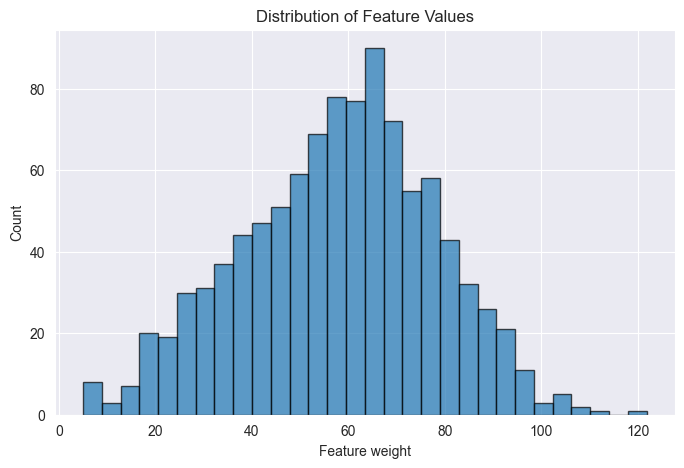

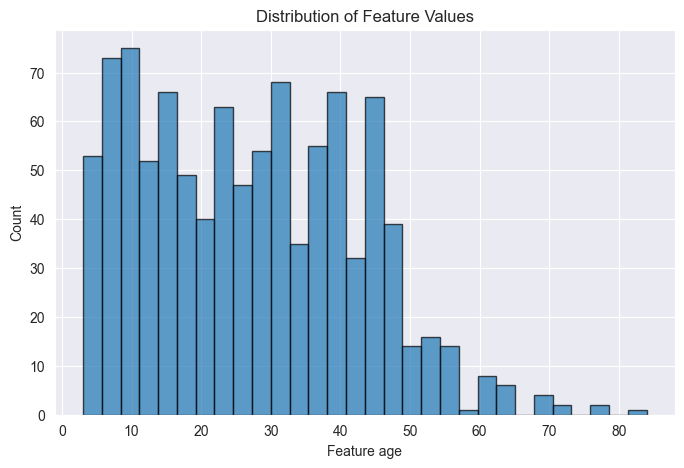

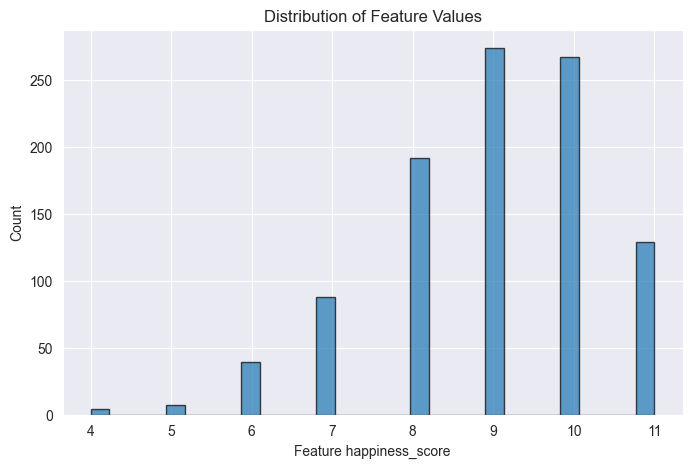

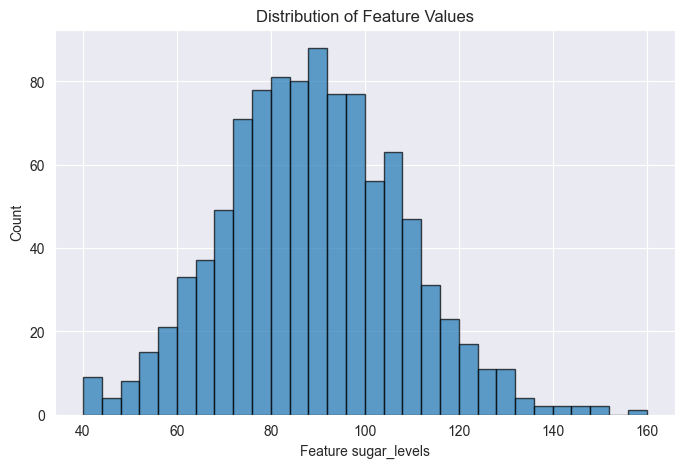

In [265]:
# Visualize the sugar levels, happiness_score, weight and age and decide on a normalization
# we didn't used these features in past HW assignments.

import matplotlib.pyplot as plt

def visualize_feat_distribution(name, train):
    feature_values = train[name]

    plt.figure(figsize=(8, 5))
    plt.hist(feature_values, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel(f"Feature {name}")
    plt.ylabel("Count")
    plt.title("Distribution of Feature Values")
    plt.grid(True)
    plt.show()

for name in ['weight', 'age', 'happiness_score', 'sugar_levels']:
    visualize_feat_distribution(name, train)


In [266]:
# make sure data is loaded correctly (commented in submission)
# assignment 2 data used

# train_hw2_path = '../wet_hw2/data/train_prepared.csv'
# test_hw2_path = '../wet_hw2/data/test_prepared.csv'
#
# def equals(l1, l2):
#     return len(l1) == len(l2) and all(v == u for v, u in zip(l1, l2))
#
#
# with open(train_hw2_path) as file:
#     train_hw2_data = pd.read_csv(file, index_col=0)
#     assert equals(train_hw2_data['patient_id'], train['patient_id'])
#
# with open(test_hw2_path) as file:
#     test_hw2_data = pd.read_csv(file, index_col=0)
#     assert equals(test_hw2_data['patient_id'], test['patient_id'])

### Preprocessing
Exactly as done in Wet HW 1.

In [267]:
def fill_numeric_nan_with_median(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col_name in df.columns:
        if df[col_name].dtype.kind in 'biufc':
            value = df[col_name].median()
        # else:
        #     value = df[col_name].mode(dropna=True)
        #     value = value.iloc[0] if not value.empty else None
            df[col_name] = df[col_name].fillna(value)
    return df

def normalize(
        df: pd.DataFrame, df2: pd.DataFrame,
        mm_scale_columns: list,
        z_scale_columns: list
) -> (pd.DataFrame, pd.DataFrame):
    df = df.copy()
    df2 = df2.copy()
    scaler_mm = MinMaxScaler(feature_range=(-1, 1))
    scaler_z = StandardScaler()

     # Fit on train only, transform both train and test
    df[mm_scale_columns] = scaler_mm.fit_transform(df[mm_scale_columns])
    df[z_scale_columns] = scaler_z.fit_transform(df[z_scale_columns])

    df2[mm_scale_columns] = scaler_mm.transform(df2[mm_scale_columns])
    df2[z_scale_columns] = scaler_z.transform(df2[z_scale_columns])
    return df, df2

def preprocess(df: pd.DataFrame, df2: pd.DataFrame, mm_scale_columns, z_scale_columns) -> (pd.DataFrame, pd.DataFrame):
    df = df.copy()
    df2 = df2.copy()
    df = fill_numeric_nan_with_median(df)
    df2 = fill_numeric_nan_with_median(df2)
    return normalize(df, df2,  mm_scale_columns, z_scale_columns)


mm_scale_columns = ['PCR_01', 'PCR_02', 'PCR_04', 'PCR_06', 'PCR_08', 'age', 'happiness_score']
z_scale_columns = ['PCR_03', 'PCR_05', 'PCR_07', 'PCR_09', 'PCR_10', 'weight', 'sugar_levels']

train, test = preprocess(train, test, mm_scale_columns, z_scale_columns)

# we don't want to train using the patient_id as feature as it is unrelated to the end result.
train.drop(columns=['patient_id'], inplace=True)
test.drop(columns=['patient_id'], inplace=True)

## Section 1: Linear regression implementation

#### (Q1)

In [268]:
import LinearRegressor as LR

### load new division for the dataset

####  (Q2)

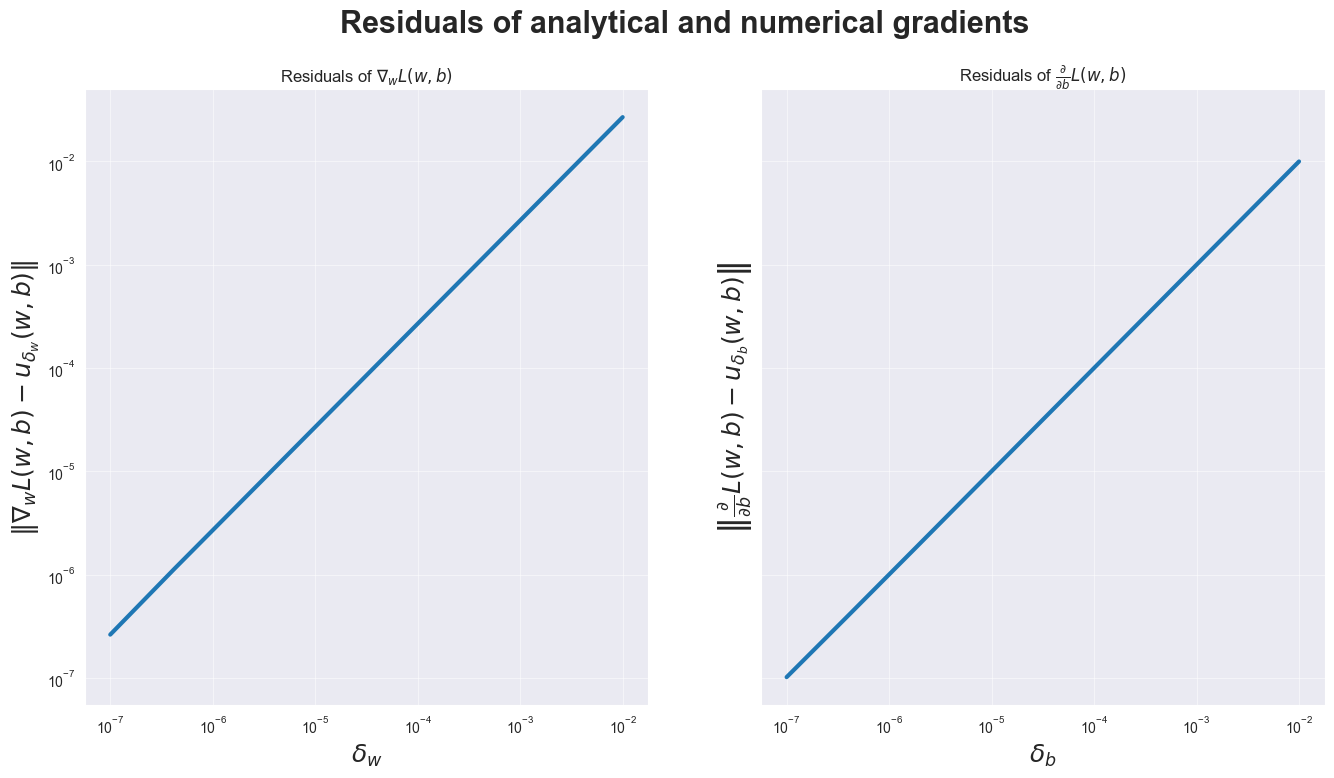

In [269]:
# divide to train and test using the ID's (same method as in Wet HW 1)
train_new = train.sample(frac=0.8, random_state=42)
validation_new = train.drop(train_new.index)

# train_new, validation_new = normalize(train_new, validation_new, mm_scale_columns, z_scale_columns)
X_train = train_new.drop(columns=['contamination_level']).to_numpy()
y_train = train_new['contamination_level'].to_numpy()

X_val = validation_new.drop(columns=['contamination_level']).to_numpy()
y_val = validation_new['contamination_level'].to_numpy()

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

#### (Q3)

lr size = 1e-09, Best train loss = 0.1446383189500582, Best validation loss = 0.14791635472618225
lr size = 1e-08, Best train loss = 0.14463018333361094, Best validation loss = 0.14790803679315967
lr size = 1e-07, Best train loss = 0.14454885941639067, Best validation loss = 0.14782489034989177
lr size = 1e-06, Best train loss = 0.14373883632999382, Best validation loss = 0.14699670584950103
lr size = 1e-05, Best train loss = 0.13595174635194096, Best validation loss = 0.13903426385463666
lr size = 0.0001, Best train loss = 0.08239990119728892, Best validation loss = 0.08424675755674789
lr size = 0.001, Best train loss = 0.02969892059967759, Best validation loss = 0.03127965409266877
lr size = 0.01, Best train loss = 0.027707920943345225, Best validation loss = 0.029004063932262375
lr size = 0.1, Best train loss = 0.02779468498725595, Best validation loss = 0.028455464063358863


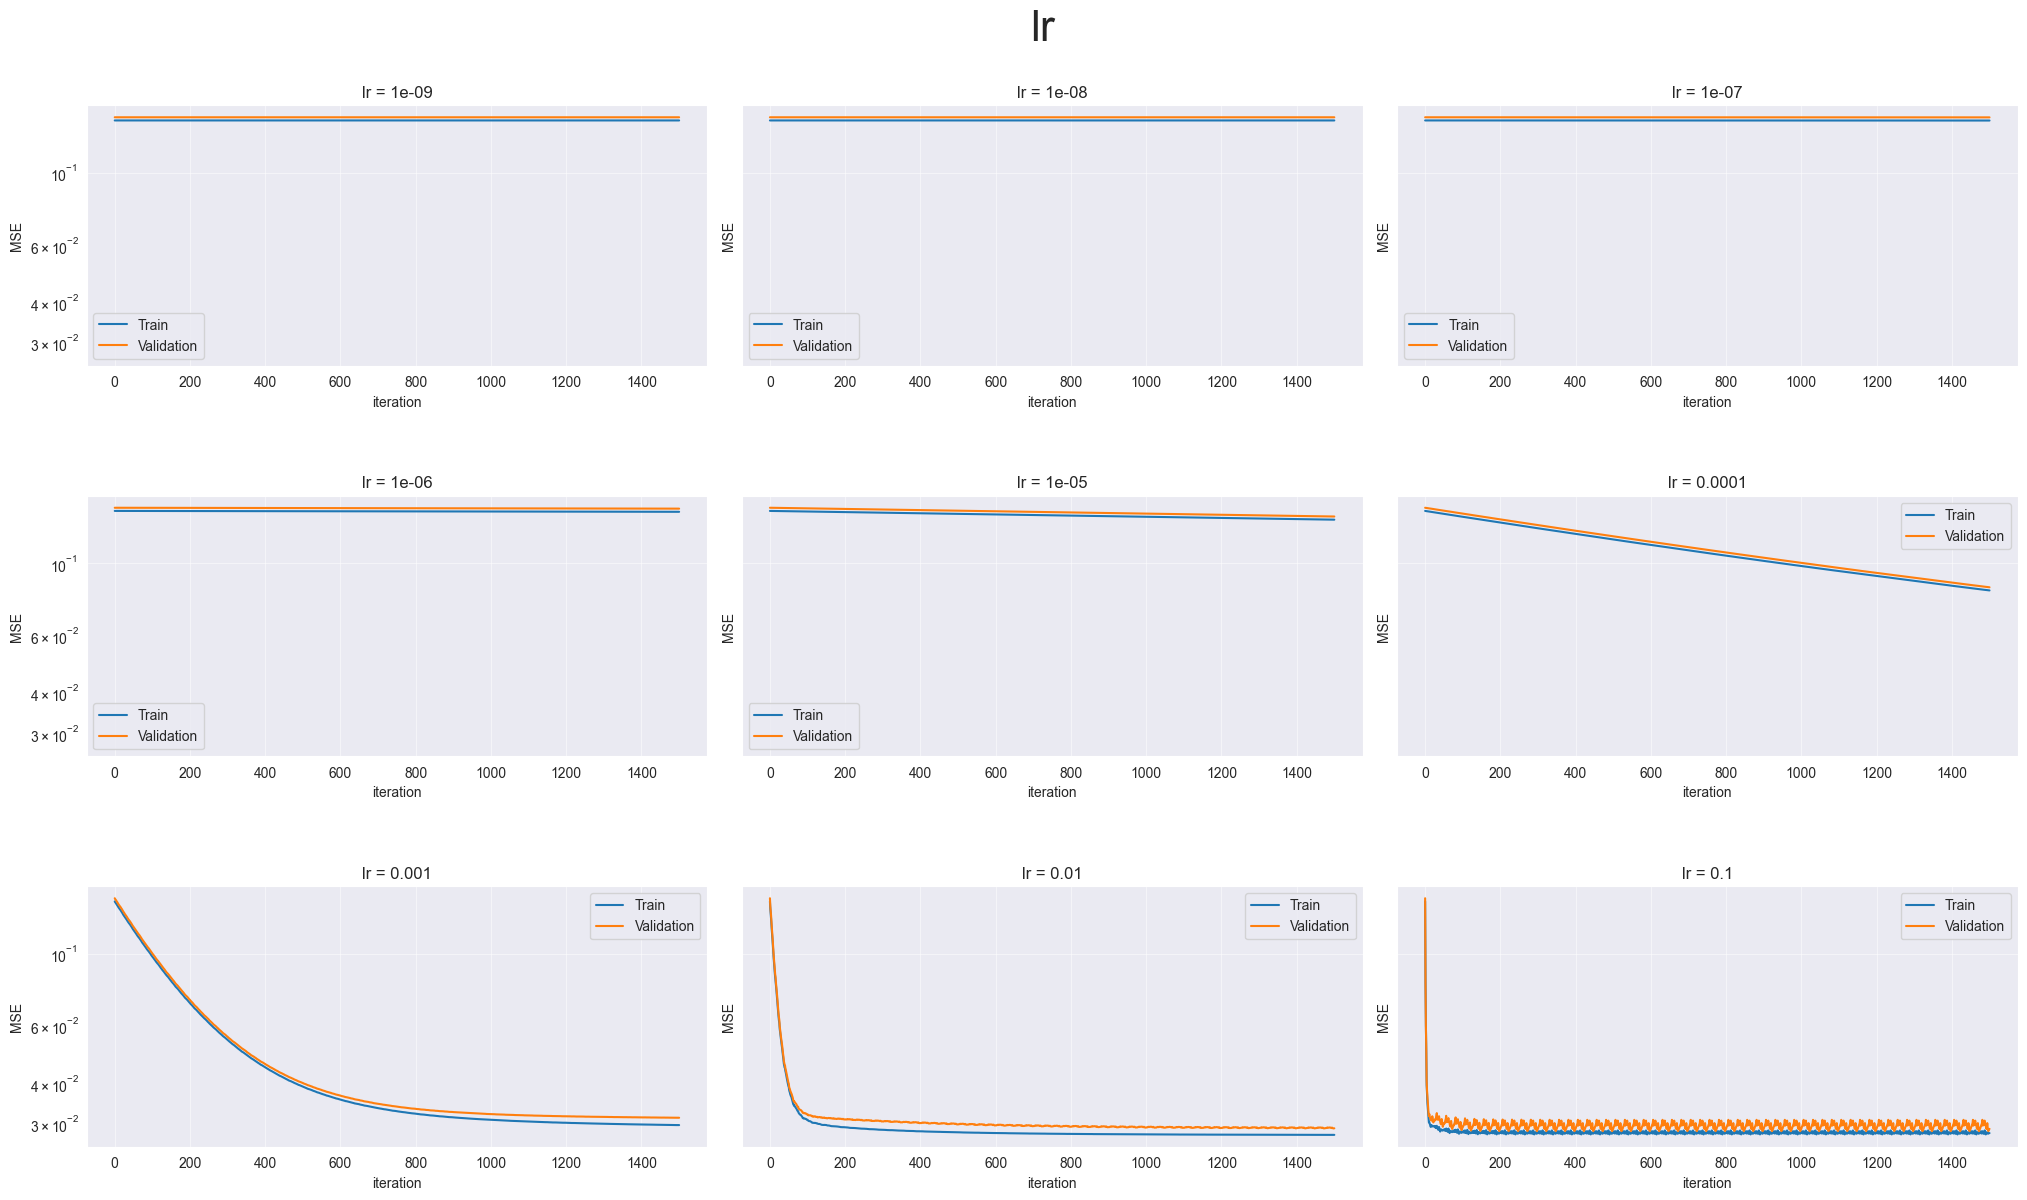

In [270]:
# def check_nan_inf(df, name="Data"):
#     print(f"Checking {name}...")
#     print(" - Any NaNs:", df.isna().values.any())
#     print(" - Any Infs:", np.isinf(df.values).any())
#     print(" - Any non-finite values:", not np.all(np.isfinite(df.values)))
#
# check_nan_inf(pd.DataFrame(X_train), "X_train")
# check_nan_inf(pd.Series(y_train), "y_train")
# check_nan_inf(pd.DataFrame(X_val), "X_val")
# check_nan_inf(pd.Series(y_val), "y_val")
test_lr(X_train, y_train, X_val, y_val, title='lr')

## Section 2: Evaluation and Baseline

### Simplest baselin

 #### (Q4)

In [271]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error as MSE


X_train = train.drop(columns=['contamination_level']).to_numpy()
y_train = train['contamination_level'].to_numpy()

X_test = test.drop(columns=['contamination_level']).to_numpy()
y_test = test['contamination_level'].to_numpy()

dummy_reg = DummyRegressor(strategy='mean')
scores_dummy = cross_validate(dummy_reg, X_train, y_train, scoring=make_scorer(MSE), cv=5, return_train_score=True)

In [272]:
scores = {
    'Model': ['Dummy'],
    'Section': [2],
    'Train MSE': [np.mean(scores_dummy['train_score'])],
    'Valid MSE': [np.mean(scores_dummy['test_score'])],
}
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE'], index=[0])

,Model,Section,Train MSE,Valid MSE
0,Dummy,2,0.044511,0.044573


#### TASK

In [273]:
dummy_reg_full = DummyRegressor(strategy='mean')

dummy_reg_full.fit(X_train, y_train)

DummyRegressor()

### Basic hyperparameter tuning

#### (Q5)

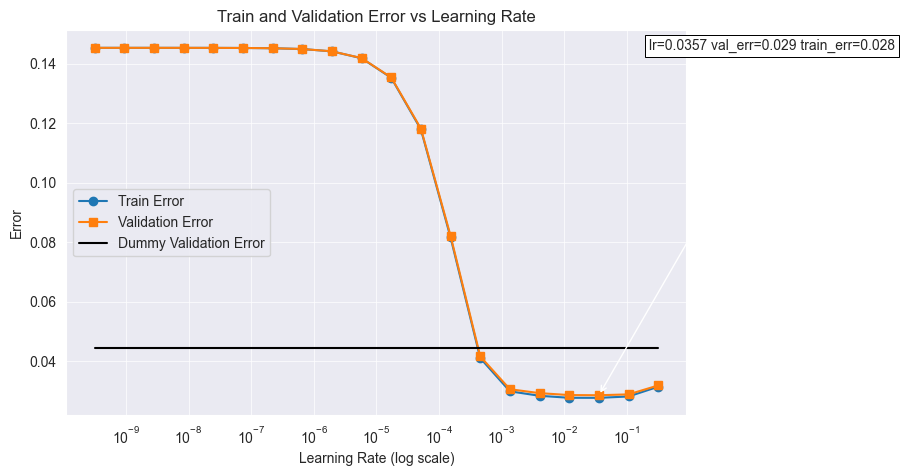

In [274]:
tuning_opt = {}
lr_list = np.logspace(-9.5, -0.5, 20)


def annot_min(x, y, y2, ax=None):
    x_min = x[np.argmin(y)]
    y_min = y.min()
    y2_min = y2[np.argmin(y)]
    text= "lr={:.4f} val_err={:.3f} train_err={:.3f}".format(x_min, y_min, y2_min)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="center")
    ax.annotate(text, xy=(x_min, y_min), xytext=(0.94,0.96), **kw)
    return x_min, y_min, y2_min

for lr in lr_list:
    regressor_scores = cross_validate(
        LR.LinearRegressor(lr),
        X_train,
        y_train,
        scoring=make_scorer(MSE),
        cv=5,
        return_train_score=True
    )
    train_loss = np.mean(regressor_scores['train_score'])
    val_loss = np.mean(regressor_scores['test_score'])
    tuning_opt[lr] = {'train_error': train_loss, 'val_error': val_loss}


plt.figure(figsize=(8, 5))
train_errors = [v['train_error'] for v  in tuning_opt.values()]
validation_errors = [v['val_error'] for v  in tuning_opt.values()]

plt.semilogx(lr_list, train_errors , marker='o', label='Train Error')
plt.semilogx(lr_list, validation_errors , marker='s', label='Validation Error')
plt.semilogx(lr_list, [scores['Valid MSE'][0] for _  in tuning_opt.values()], color='black', label='Dummy Validation Error')

plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Error")
plt.title("Train and Validation Error vs Learning Rate")
plt.legend()
plt.grid(True, alpha=0.7)

best_lr_res = annot_min(lr_list, np.array(validation_errors), np.array(train_errors))
plt.show()


scores['Model'].append(f'Linear (lr={best_lr_res[0]:.4f})')
scores['Section'].append(2)
scores['Train MSE'].append(best_lr_res[2])
scores['Valid MSE'].append(best_lr_res[1])

In [275]:
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE'], index=[0, 1])

,Model,Section,Train MSE,Valid MSE
0,Dummy,2,0.044511,0.044573
1,Linear (lr=0.0357),2,0.027783,0.028658


#### (Q6) - in report

#### TASK

In [276]:
linear_reg_best = LR.LinearRegressor(lr=best_lr_res[0])
linear_reg_best = linear_reg_best.fit(X_train, y_train)

## Section 3: Lasso linear regression

In [277]:
from sklearn.linear_model import Lasso

#### (Q7) + (Q8)

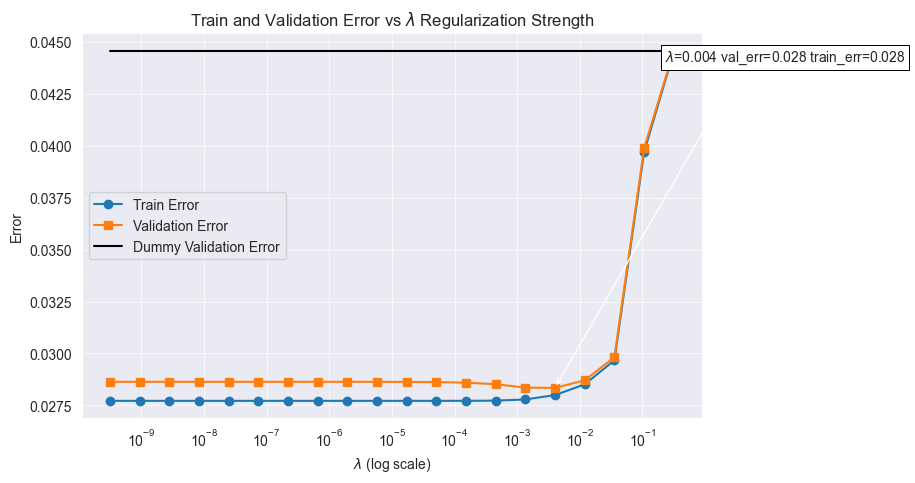

In [278]:
tuning_opt = {}
lambda_list = np.logspace(-9.5, -0.5, 20)


def annot_min(x, y, y2, ax=None):
    x_min = x[np.argmin(y)]
    y_min = y.min()
    y2_min = y2[np.argmin(y)]
    text= r"$\lambda$={:.3f} val_err={:.3f} train_err={:.3f}".format(x_min, y_min, y2_min)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(x_min, y_min), xytext=(0.94,0.96), **kw)
    return x_min, y_min, y2_min

for lambda_r in lambda_list:
    regressor_scores = cross_validate(
        Lasso(alpha=lambda_r, fit_intercept=True),
        X_train,
        y_train,
        scoring=make_scorer(MSE),
        cv=5,
        return_train_score=True
    )
    train_loss = np.mean(regressor_scores['train_score'])
    val_loss = np.mean(regressor_scores['test_score'])
    tuning_opt[lambda_r] = {'train_error': train_loss, 'val_error': val_loss}


plt.figure(figsize=(8, 5))
train_errors = [v['train_error'] for v  in tuning_opt.values()]
validation_errors = [v['val_error'] for v  in tuning_opt.values()]

plt.semilogx(lambda_list, train_errors, marker='o', label='Train Error')
plt.semilogx(lambda_list, validation_errors, marker='s', label='Validation Error')
plt.semilogx(lambda_list, [scores['Valid MSE'][0] for _ in tuning_opt.values()], color='black', label='Dummy Validation Error')

plt.xlabel("$\lambda$ (log scale)")
plt.ylabel("Error")
plt.title("Train and Validation Error vs $\lambda$ Regularization Strength")
plt.legend()
plt.grid(True, alpha=0.7)

best_lambda_res = annot_min(lambda_list, np.array(validation_errors), np.array(train_errors))
plt.show()


scores['Model'].append(f'Lasso Linear (lambda={best_lambda_res[0]:.4f})')
scores['Section'].append(3)
scores['Train MSE'].append(best_lambda_res[2])
scores['Valid MSE'].append(best_lambda_res[1])

In [279]:
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE'], index=[0, 1, 2])

,Model,Section,Train MSE,Valid MSE
0,Dummy,2,0.044511,0.044573
1,Linear (lr=0.0357),2,0.027783,0.028658
2,Lasso Linear (lambda=0.0040),3,0.027996,0.028343


#### TASK

In [280]:
linear_lasso_reg_best = Lasso(alpha=best_lambda_res[0], fit_intercept=True)
linear_lasso_reg_best.fit(X_train, y_train)

Lasso(alpha=np.float64(0.0040296113202003955))

#### (Q9) - table

In [281]:
importance_table_lasso = pd.DataFrame({
    'Feature': train.drop(columns=['contamination_level']).columns,
    'Coefficient': linear_lasso_reg_best.coef_
})

# Sort by absolute importance
importance_table_lasso['Importance'] = importance_table_lasso['Coefficient'].abs()
importance_table_lasso = importance_table_lasso.sort_values(by='Importance', ascending=False)
importance_table_lasso

,Feature,Coefficient,Importance
3,sugar_levels,0.123014,0.123014
5,PCR_01,0.019175,0.019175
4,PCR_03,0.007955,0.007955
8,PCR_05,-0.002233,0.002233
1,weight,0.000000,0.000000
0,age,0.000000,0.000000
2,happiness_score,-0.000000,0.000000
6,PCR_02,-0.000000,0.000000
7,PCR_04,-0.000000,0.000000
9,PCR_06,-0.000000,0.000000


#### (Q10) - table

In [282]:
importance_table_ridge = pd.DataFrame({
    'Feature': train.drop(columns=['contamination_level']).columns,
    'Coefficient': linear_reg_best.w
})

# Sort by absolute importance
importance_table_ridge['Importance'] = importance_table_ridge['Coefficient'].abs()
importance_table_ridge = importance_table_ridge.sort_values(by='Importance', ascending=False)
importance_table_ridge

,Feature,Coefficient,Importance
3,sugar_levels,0.130796,0.130796
5,PCR_01,0.036406,0.036406
2,happiness_score,-0.020590,0.020590
4,PCR_03,0.009071,0.009071
9,PCR_06,-0.008054,0.008054
7,PCR_04,-0.007363,0.007363
12,PCR_09,-0.006979,0.006979
8,PCR_05,-0.006240,0.006240
13,PCR_10,-0.002951,0.002951
0,age,0.001261,0.001261


#### (Q11) - in docs

#### (Q12)

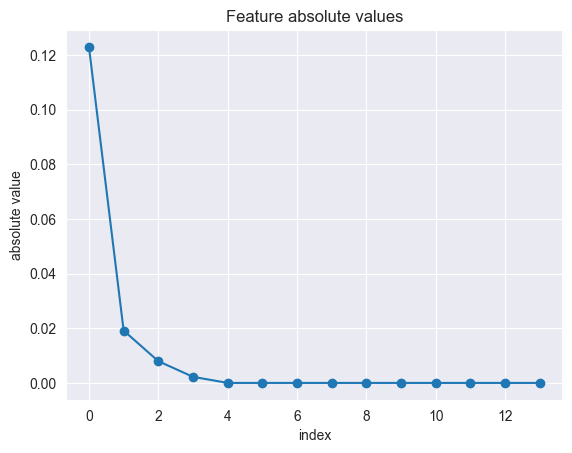

In [283]:
plt.plot(range(len(importance_table_lasso['Importance'])), importance_table_lasso['Importance'], marker='o')
plt.xlabel("index")
plt.ylabel("absolute value")
plt.title("Feature absolute values")

# Show the plot
plt.show()

## Section 4: Polynomial fitting (visualization)

#### TASK

In [284]:
pcr28 = ['PCR_08', 'PCR_02']
train28 = train[pcr28 + ['contamination_level']]
X_train28 = train[pcr28].to_numpy()
X_test28 = test[pcr28].to_numpy()

#### TASK

C:\Dev\ML-02360766\wet_hw3\plot3d.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


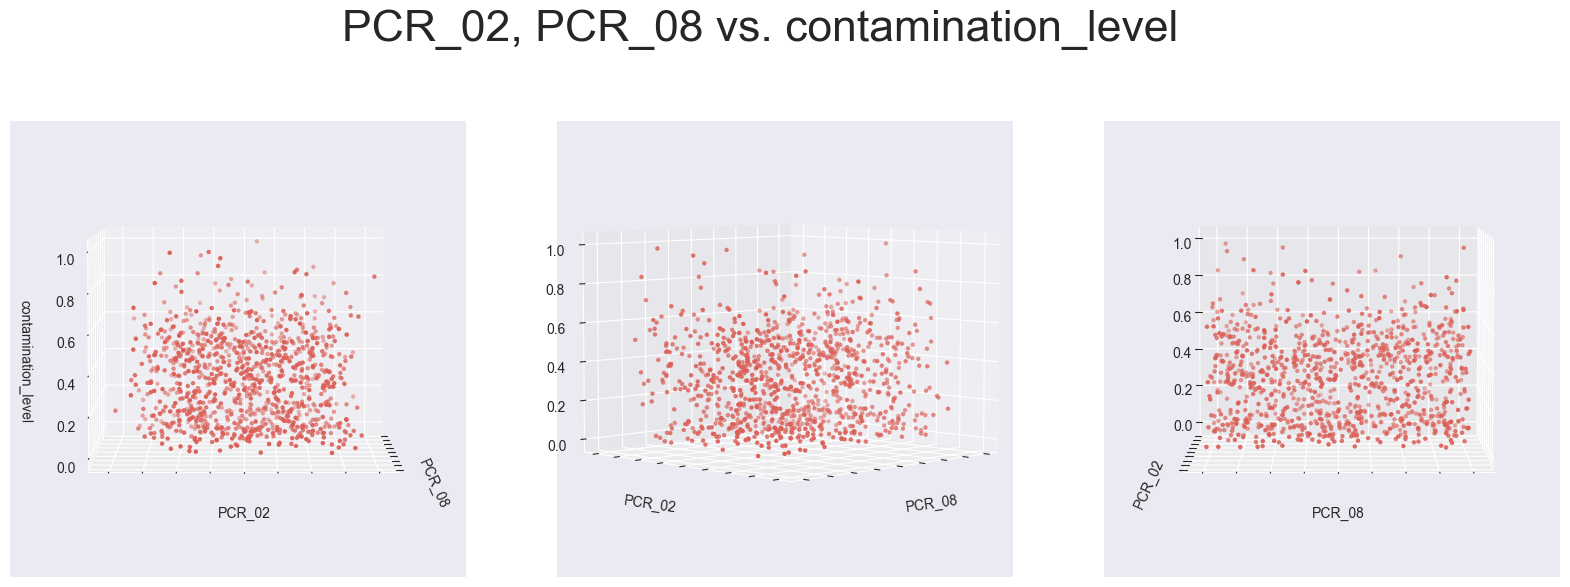

In [285]:
plot3d(train28, *pcr28, 'contamination_level', title=f'PCR_02, PCR_08 vs. contamination_level')

#### TASK

In [286]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Lambda = best_lambda_res[0]
# poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
#     ('normalization', MinMaxScaler(feature_range=(-1, 1))),
#     ('Lasso', Lasso(alpha=Lambda, fit_intercept=True))])

#### (Q13) - in report

#### (Q14)

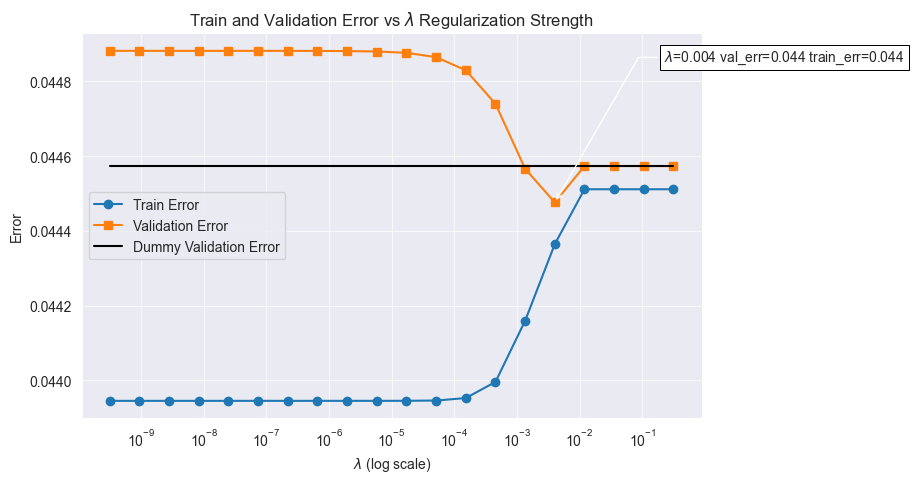

In [287]:
tuning_opt = {}
lambda_list = np.logspace(-9.5, -0.5, 20)

def annot_min(x, y, y2, ax=None):
    x_min = x[np.argmin(y)]
    y_min = y.min()
    y2_min = y2[np.argmin(y)]
    text= r"$\lambda$={:.3f} val_err={:.3f} train_err={:.3f}".format(x_min, y_min, y2_min)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(x_min, y_min), xytext=(0.94,0.96), **kw)
    return x_min, y_min, y2_min

for lambda_r in lambda_list:
    poly_reg = Pipeline([
        ('feature_mapping', PolynomialFeatures(degree=3)),
        ('normalization', MinMaxScaler(feature_range=(-1, 1))),
        ('Lasso', Lasso(alpha=lambda_r, fit_intercept=True))
    ])
    regressor_scores = cross_validate(
        poly_reg,
        X_train28,
        y_train,
        scoring=make_scorer(MSE),
        cv=5,
        return_train_score=True
    )
    train_loss = np.mean(regressor_scores['train_score'])
    val_loss = np.mean(regressor_scores['test_score'])
    tuning_opt[lambda_r] = {'train_error': train_loss, 'val_error': val_loss}

plt.figure(figsize=(8, 5))
train_errors = [v['train_error'] for v  in tuning_opt.values()]
validation_errors = [v['val_error'] for v  in tuning_opt.values()]

plt.semilogx(lambda_list, train_errors, marker='o', label='Train Error')
plt.semilogx(lambda_list, validation_errors, marker='s', label='Validation Error')
plt.semilogx(lambda_list, [scores['Valid MSE'][0] for _ in tuning_opt.values()], color='black', label='Dummy Validation Error')

plt.xlabel("$\lambda$ (log scale)")
plt.ylabel("Error")
plt.title("Train and Validation Error vs $\lambda$ Regularization Strength")
plt.legend()
plt.grid(True, alpha=0.7)

best_lambda_res = annot_min(lambda_list, np.array(validation_errors), np.array(train_errors))
plt.show()


scores['Model'].append(f'Polynomial Lasso (lambda={best_lambda_res[0]:.4f})')
scores['Section'].append(4)
scores['Train MSE'].append(best_lambda_res[2])
scores['Valid MSE'].append(best_lambda_res[1])

#### TASK

In [288]:
poly_lasso_reg_best = poly_reg = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3)),
    ('normalization', MinMaxScaler(feature_range=(-1, 1))),
    ('Lasso', Lasso(alpha=best_lambda_res[0], fit_intercept=True))
])
poly_lasso_reg_best.fit(X_train, y_train)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler(feature_range=(-1, 1))),
                ('Lasso', Lasso(alpha=np.float64(0.0040296113202003955)))])

#### (Q15)

C:\Dev\ML-02360766\wet_hw3\plot3d.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


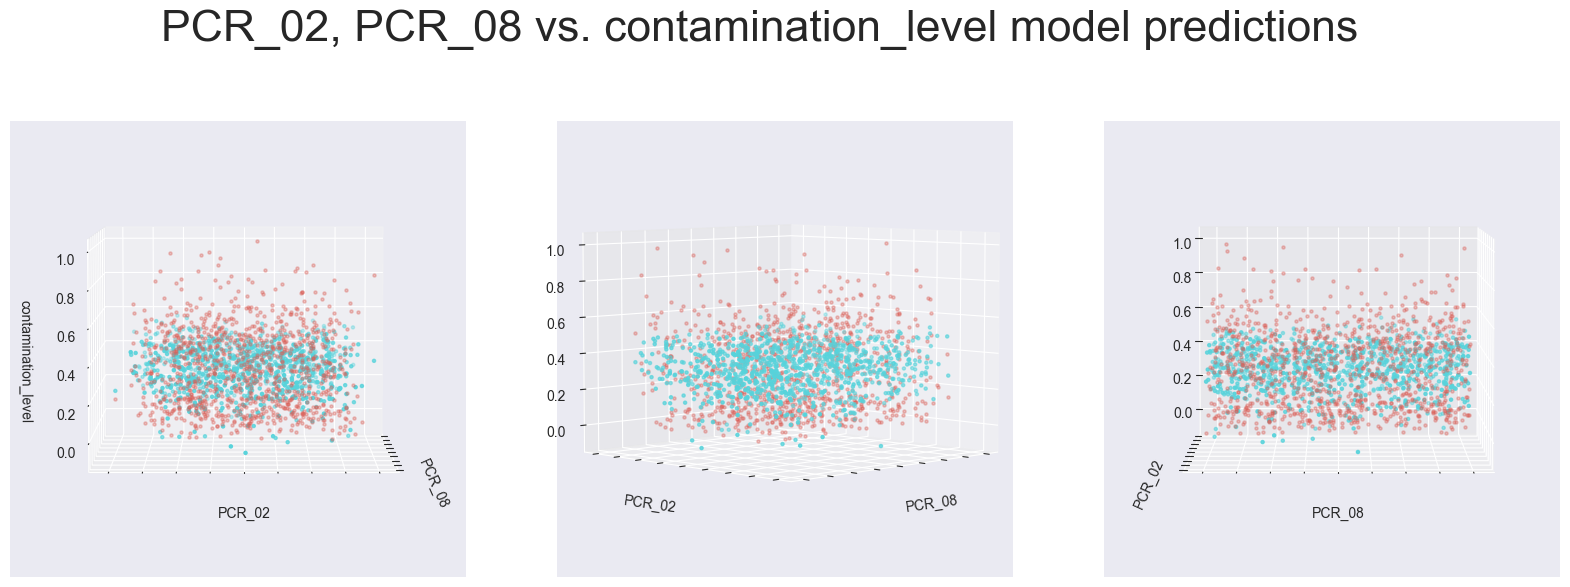

In [289]:
plot3d(train28, *pcr28, 'contamination_level',
       title=f'PCR_02, PCR_08 vs. contamination_level model predictions',
       predictions=poly_lasso_reg_best.predict(X_train))

#### (Q16)

In [290]:
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE'], index=[0, 1, 2, 3])

,Model,Section,Train MSE,Valid MSE
0,Dummy,2,0.044511,0.044573
1,Linear (lr=0.0357),2,0.027783,0.028658
2,Lasso Linear (lambda=0.0040),3,0.027996,0.028343
3,Polynomial Lasso (lambda=0.0040),4,0.044365,0.044476


## Section 5: Fitting Gradient Boosted Machines (GBM)

In [291]:
from sklearn.ensemble import GradientBoostingRegressor as GBM
import seaborn as sns


#### TASK

In [292]:
trainGBM = train28.copy()

#### (Q17)

In [211]:
# learn the training data
min_samples_leaf_range = [1] + list(range(15, 300 + 1, 15))
learning_rate_range = np.logspace(-6, -1, 6)

hyperparameters = {
    'learning_rate': learning_rate_range,
    'min_samples_leaf': min_samples_leaf_range,
    'loss': ['huber']
}

grid_search = GridSearchCV(
    GBM(),
    scoring=make_scorer(MSE),
    param_grid=hyperparameters,
    return_train_score=True,
    cv=5
)
grid_search.fit(trainGBM, y_train)
res = pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.267218,0.046498,0.001605,0.000506,0.000001,huber,1,"{'learning_rate': 1e-06, 'loss': 'huber', 'min...",0.047077,0.044715,...,0.044568,0.003456,17,0.043945,0.044477,0.043998,0.044032,0.046237,0.044538,0.000871
1,0.252334,0.029435,0.001402,0.000488,0.000001,huber,15,"{'learning_rate': 1e-06, 'loss': 'huber', 'min...",0.047077,0.044715,...,0.044568,0.003456,17,0.043945,0.044477,0.043998,0.044032,0.046237,0.044538,0.000871
2,0.252675,0.019276,0.001263,0.000511,0.000001,huber,30,"{'learning_rate': 1e-06, 'loss': 'huber', 'min...",0.047077,0.044715,...,0.044568,0.003456,17,0.043945,0.044477,0.043998,0.044032,0.046237,0.044538,0.000871
3,0.252961,0.008380,0.001083,0.000150,0.000001,huber,45,"{'learning_rate': 1e-06, 'loss': 'huber', 'min...",0.047077,0.044715,...,0.044568,0.003456,17,0.043945,0.044477,0.043998,0.044032,0.046237,0.044538,0.000871
4,0.240059,0.007420,0.001484,0.000595,0.000001,huber,60,"{'learning_rate': 1e-06, 'loss': 'huber', 'min...",0.047077,0.044715,...,0.044568,0.003456,21,0.043945,0.044477,0.043998,0.044032,0.046237,0.044538,0.000871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.130688,0.009639,0.001732,0.000475,0.100000,huber,240,"{'learning_rate': 0.1, 'loss': 'huber', 'min_s...",0.005902,0.004481,...,0.004646,0.001442,110,0.004269,0.004619,0.004069,0.004834,0.004997,0.004558,0.000345
122,0.132493,0.011535,0.001035,0.000046,0.100000,huber,255,"{'learning_rate': 0.1, 'loss': 'huber', 'min_s...",0.006277,0.004944,...,0.005058,0.001548,109,0.004708,0.005052,0.004491,0.005323,0.005479,0.005011,0.000369
123,0.106628,0.005734,0.001201,0.000400,0.100000,huber,270,"{'learning_rate': 0.1, 'loss': 'huber', 'min_s...",0.006676,0.005589,...,0.005585,0.001666,108,0.005219,0.005524,0.004995,0.005869,0.006001,0.005522,0.000379
124,0.111113,0.007657,0.001399,0.000485,0.100000,huber,285,"{'learning_rate': 0.1, 'loss': 'huber', 'min_s...",0.007071,0.005989,...,0.006121,0.001746,107,0.005750,0.006033,0.005524,0.006459,0.006557,0.006065,0.000397


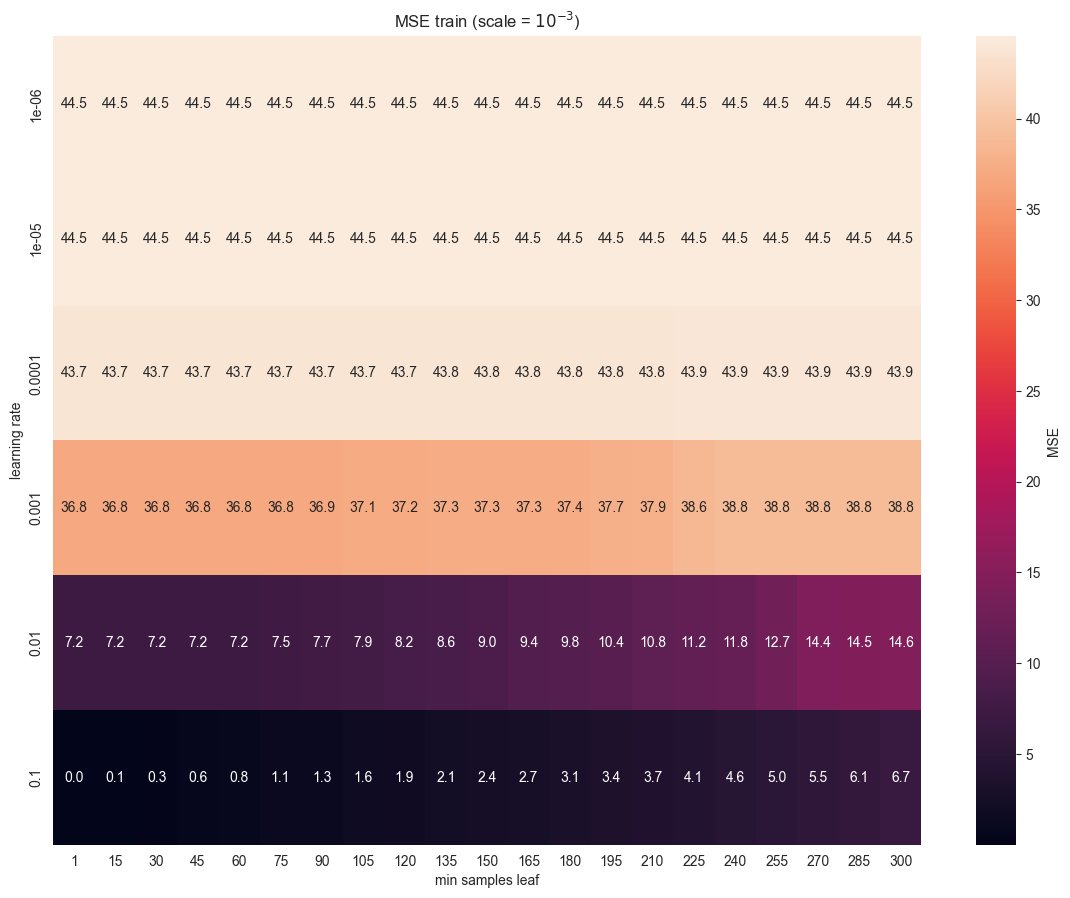

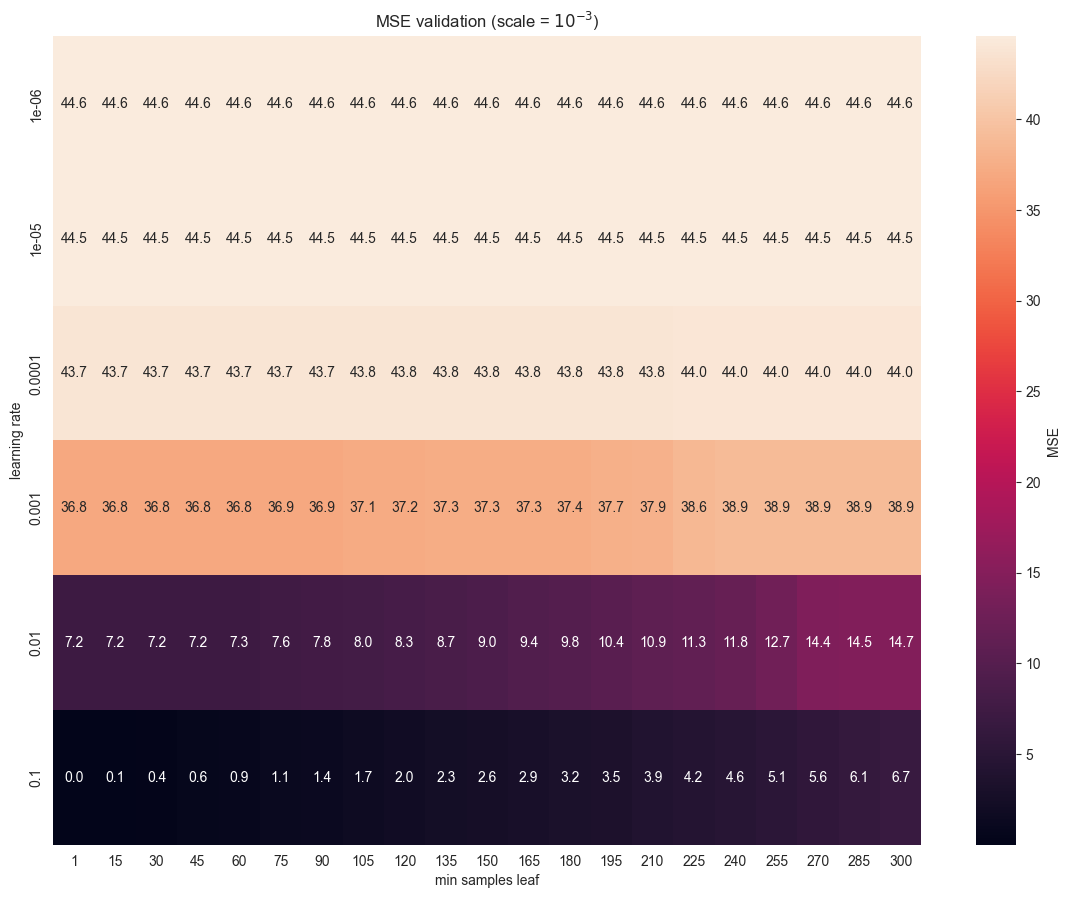

In [212]:
# Train heatmap
heatmap_data_train = res.pivot(
    index='param_learning_rate',
    columns='param_min_samples_leaf',
    values='mean_train_score'
) / 1e-3

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_train, annot=True, fmt=".1f", cbar_kws={'label': 'MSE'})
plt.title("MSE train (scale = $10^{-3}$)")
plt.xlabel("min samples leaf")
plt.ylabel("learning rate")
plt.show()


# Validation heatmap
heatmap_data_validation = res.pivot(
    index='param_learning_rate',
    columns='param_min_samples_leaf',
    values='mean_test_score'
) / 1e-3

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_validation, annot=True, fmt=".1f", cbar_kws={'label': 'MSE'})
plt.title("MSE validation (scale = $10^{-3}$)")
plt.xlabel("min samples leaf")
plt.ylabel("learning rate")
plt.show()

#### (Q18)

In [293]:
scores['Model'].append(f'GBM Regressor')
scores['Section'].append(5)
best_res_config = {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 1}

index = [i for i, params in enumerate(res['params']) if params == best_res_config][0]
scores['Train MSE'].append(res['mean_train_score'][index])
scores['Valid MSE'].append(res['mean_test_score'][index])

In [294]:
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE'], index=[0, 1, 2, 3, 4])

,Model,Section,Train MSE,Valid MSE
0,Dummy,2,0.044511,0.044573
1,Linear (lr=0.0357),2,0.027783,0.028658
2,Lasso Linear (lambda=0.0040),3,0.027996,0.028343
3,Polynomial Lasso (lambda=0.0040),4,0.044365,0.044476
4,GBM Regressor,5,0.000002,0.000006


#### TASK

In [295]:
best_gbm = GBM(learning_rate=0.1, min_samples_leaf=1)
best_gbm.fit(X_train, y_train)

GradientBoostingRegressor()

#### (Q19) - in docs

## Section 6: Testing your models

In [296]:
test_mse = [
    MSE(y_test, dummy_reg_full.predict(X_test)),
    MSE(y_test, linear_reg_best.predict(X_test)),
    MSE(y_test, linear_lasso_reg_best.predict(X_test)),
    MSE(y_test, poly_lasso_reg_best.predict(X_test)),
    MSE(y_test, best_gbm.predict(X_test))
]
scores['Test MSE'] = test_mse
pd.DataFrame(scores, columns=['Model', 'Section', 'Train MSE', 'Valid MSE', 'Test MSE'], index=[0, 1, 2, 3, 4])

,Model,Section,Train MSE,Valid MSE,Test MSE
0,Dummy,2,0.044511,0.044573,0.039217
1,Linear (lr=0.0357),2,0.027783,0.028658,0.024342
2,Lasso Linear (lambda=0.0040),3,0.027996,0.028343,0.024097
3,Polynomial Lasso (lambda=0.0040),4,0.044365,0.044476,0.023312
4,GBM Regressor,5,0.000002,0.000006,0.016534
